# Decouple Analysis from running GPX files #
## Intro ##
### Code Set Up ###

In [1]:
#imports
import pandas as pd
import seaborn as sns
import xml.etree.ElementTree as et
import numpy as np
import math
from datetime import datetime as dt
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)

### Definitions ###
We will be attempting to confirm whether or not the uploaded activity is performed primarily at the aerobic threshold using a metric known as 'heart-rate drift'. Heart-rate drift is measured by the variability of heart rate at a specific pace. Someone exercising at their aerobic heart rate for an hour should be able to maintain their pace with their heart rate only increasing between 3% and 5%. If heart rate increases more than 5%, the effort was too hard. If heart rate increases less than 3% the effort was too easy. 

Make sure to be adequetly hydrated during the test, as heart rate drift can occur due to dehyrdation as well.

## Solution ##
### Data Structure ###
The activity is recorded in a 'GPX' format. This is an xml document with latitude, longitude, time, and other accessory variables such as heart rate or cadence.

In [119]:
#data file
run_data_file = "activity_5758749241.gpx"
#run_data_file = "activity_5737705799.gpx"
run_tree = et.parse(run_data_file)
run_root = run_tree.getroot()

#run_root[1][2][x][y] (opt: [0,z])
#x = measurement (every second)
#y = (0 , elevation), (1, time), (2, extra stats)
#z = (0, hr), (1, cadence)
print("latitude: " + run_root[1][2][0].attrib['lat'])
print("longitude: " +run_root[1][2][0].attrib['lon'])
print("elevation: " + run_root[1][2][0][0].text)
print("time: " + run_root[1][2][0][1].text)
print("heart rate: " + run_root[1][2][0][2][0][0].text)
print("cadence: " + run_root[1][2][0][2][0][1].text)

latitude: 35.2427557669579982757568359375
longitude: -81.03792320005595684051513671875
elevation: 217
time: 2020-11-01T13:48:31.000Z
heart rate: 86
cadence: 0


I think it would be easiest to work with this data in a dataframe, so I am going to create a dataframe with the full workout in it.

In [120]:
points_big_list = []
for points in run_root[1][2]:
    lat = points.attrib['lat']
    lon = points.attrib['lon']
    ele = float(points[0].text)
    time = dt.strptime(points[1].text, '%Y-%m-%dT%H:%M:%S.000Z')#.strftime('%H:%M:%S')
    hr = int(points[2][0][0].text)
    cad = int(points[2][0][1].text)
    point_list = [time,lat,lon,ele,hr,cad]
    points_big_list.append(point_list)

In [121]:
df1 = pd.DataFrame(points_big_list,columns=['Time','Latitude','Longitude','Elevation','Heart Rate','Cadence'])
df1.set_index('Time',drop=False,inplace=True)
df1.head()

,Time,Latitude,Longitude,Elevation,Heart Rate,Cadence
Time,,,,,,
2020-11-01 13:48:31,2020-11-01 13:48:31,35.2427557669579982757568359375,-81.03792320005595684051513671875,217.000000,86,0
2020-11-01 13:48:32,2020-11-01 13:48:32,35.24275618605315685272216796875,-81.03792320005595684051513671875,217.000000,86,0
2020-11-01 13:48:37,2020-11-01 13:48:37,35.2428436093032360076904296875,-81.03791582398116588592529296875,217.399994,85,87
2020-11-01 13:48:41,2020-11-01 13:48:41,35.243051983416080474853515625,-81.03789704851806163787841796875,217.600006,85,82
2020-11-01 13:48:43,2020-11-01 13:48:43,35.24313739500939846038818359375,-81.0378778539597988128662109375,217.800003,87,83


So, now we have a dataframe with all of the run data included. However, Latitude and Longitude are not particularly useful for us. What we want is distance. The formula for distance is given as:

$$ a = sin^2(\Delta \phi /2) + cos\phi_1 * cos\phi_2 * sin^2(\Delta\lambda/2) $$
$$ c = 2*atan2(\sqrt{a},\sqrt{1-a}) $$
$$ d = R * c $$
Where $\phi$ is latitude, $\lambda$ is longitude, R is earths radius (20,902,230.971129 feet)

In [122]:
def coord_dist(lat_1,lat_2,lon_1,lon_2):
    #returns distance in feet traveled from two points (lat_1,lon_1) to (lat_2,lon_2)
    lat_1 = math.radians(float(lat_1))
    lat_2 = math.radians(float(lat_2))
    lon_1 = math.radians(float(lon_1))
    lon_2 = math.radians(float(lon_2))
    a = math.sin((lat_2 - lat_1)/2)**2 + math.cos(lat_1)*math.cos(lat_2)*math.sin((lon_2-lon_1)/2)**2
    c = 2*math.atan2(a**.5,(1-a)**.5)
    R = 20902230.971129
    #print(R*c)
    return R*c

def speed(run_df):
    #Returns dataframe with Delta Time (in seconds) and Distance (in feet) from previous row. Requires dataframe with Longitude, Latitude, Time columns
    speed_df = run_df
    loc = speed_df[['Latitude','Longitude']]
    b = np.roll(loc,-1,axis=0)[:-1]
    a = loc[:-1]
    ba = zip(b[:,0],a['Latitude'],b[:,1],a['Longitude'])
    #print(list(ba))
    second = pd.Timedelta(seconds=1)
    dist = [0]
    for location in ba:
        dist_delta = coord_dist(location[0],location[1],location[2],location[3])
        dist.append(dist_delta)
    speed_df['Distance'] = dist
    delta_t_df = (np.roll(speed_df['Time'], -1) -speed_df['Time'])[:-1]
    delta_t = [0]
    delta_t[1:] = delta_t_df/second
    speed_df['Delta Time'] = delta_t
    #speed_df['Speed'] = speed_df['Distance']/(speed_df['Delta Time'])
    speed_df['Pace'] = (speed_df['Delta Time']*5280)/(speed_df['Distance'] * 60)
    return speed_df

In [123]:
speed_df = speed(df1)

Now that we have our dataframe set up with all the values we will need, it is time to begin our analysis.

### Analysis:Total Distance & Average Speed ###
For the first part of our analysis, we are interested in obtaining total distance traveled and average speed across the dataset. This will allow us to easily check the accuracy of our equation, as we can check against the formula used at Garmin or Strava. Distance should be fairly easy, as we will sum up all the numbers in the distance column, and convert to miles. Time will be similarly simple, as we can just take the time delta of the first and last rows. It might be interesting to try and drop time entries that have no distance travelled in the future.

In [124]:
distance_total_ft = speed_df['Distance'].sum()
distance_total_mile = distance_total_ft/5280
time_total_min = speed_df['Delta Time'].sum()/60
pace = time_total_min/distance_total_mile
print("Distance: " + str(distance_total_mile) + " Miles\n" + "Time: " + str(time_total_min) + " Minutes\n" + "Pace: " + str(pace) + " Min/Mile" )

Distance: 9.0161014538693 Miles
Time: 95.31666666666666 Minutes
Pace: 10.571827208727901 Min/Mile


This tracks with the Garmin Connect data fairly well. Garmin connect has: 1:33:56 for time (moving), 1:35:19 elapsed time, 9.01 miles, and 10:25 min/mile average pace. In an effort to get closer to Garmins numbers, lets drop every row with a high entry for pace.

In [125]:
speed_df_clean = speed_df[(speed_df['Cadence']>70) & (speed_df['Pace'] < 16)]
speed_df_clean = speed_df_clean.copy()
distance_total_ft = speed_df_clean['Distance'].sum()
distance_total_mile = distance_total_ft/5280
time_total_min = speed_df_clean['Delta Time'].sum()/60
pace = time_total_min/distance_total_mile
print("Distance: " + str(distance_total_mile) + " Miles\n" + "Time: " + str(time_total_min) + " Minutes\n" + "Pace: " + str(pace) + " Min/Mile" )

Distance: 8.852025793690972 Miles
Time: 91.13333333333334 Minutes
Pace: 10.295195185523072 Min/Mile


It seems like Garmin subtracts the time of low movement sections, but does not subtract the distance. By dropping all distances moved that were less than 5 feet we get the above data. This is closer to Garmin, but not exactly the same. However, I am happy with it and I believe it is accurate.
<br><br>
Next, I would like to add in average heart rate to the mix. We will be working with the cleaned dataframe here.

In [126]:
speed_df_clean['hr_weighted'] = speed_df_clean['Heart Rate'] * speed_df_clean['Delta Time']
hr_weighted = speed_df_clean['hr_weighted'].sum()
avg_hr = hr_weighted/speed_df_clean['Delta Time'].sum()
print("Average HR: " + str(avg_hr) + " Beats/Min")

Average HR: 158.5382223847842 Beats/Min


Great! This tracks similarly with Garmin too, with Garmin coming in at 159 BPM.
<br><br>
Now, lets graph all of this! We will probably want a cumulative distance and cumulative time column for simplicity.

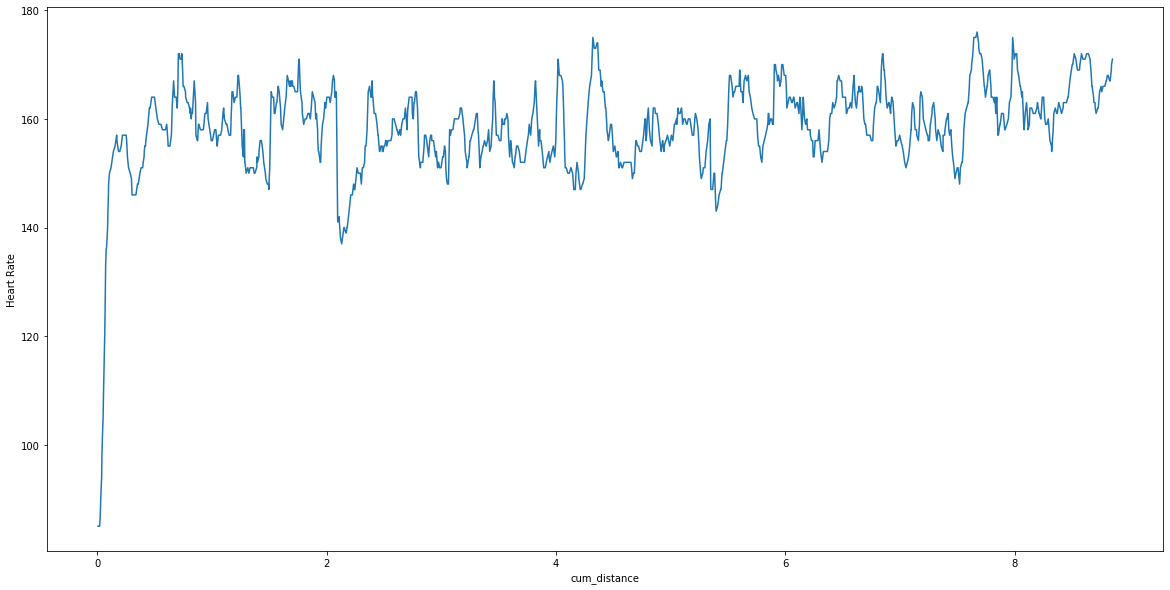

In [127]:
speed_df_clean['cum_distance'] = speed_df_clean['Distance'].cumsum()/5280
sns.lineplot(x='cum_distance', y='Heart Rate', data = speed_df_clean)

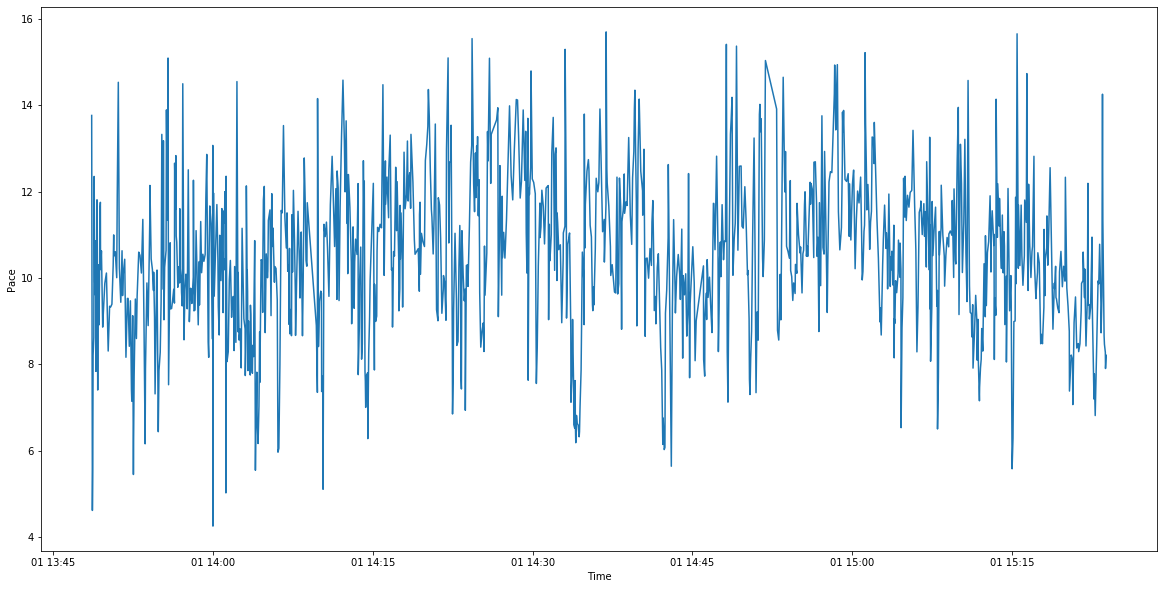

In [130]:
sns.lineplot(x='Time', y = 'Pace', data = speed_df_clean)

Graph is messy, lets resample.

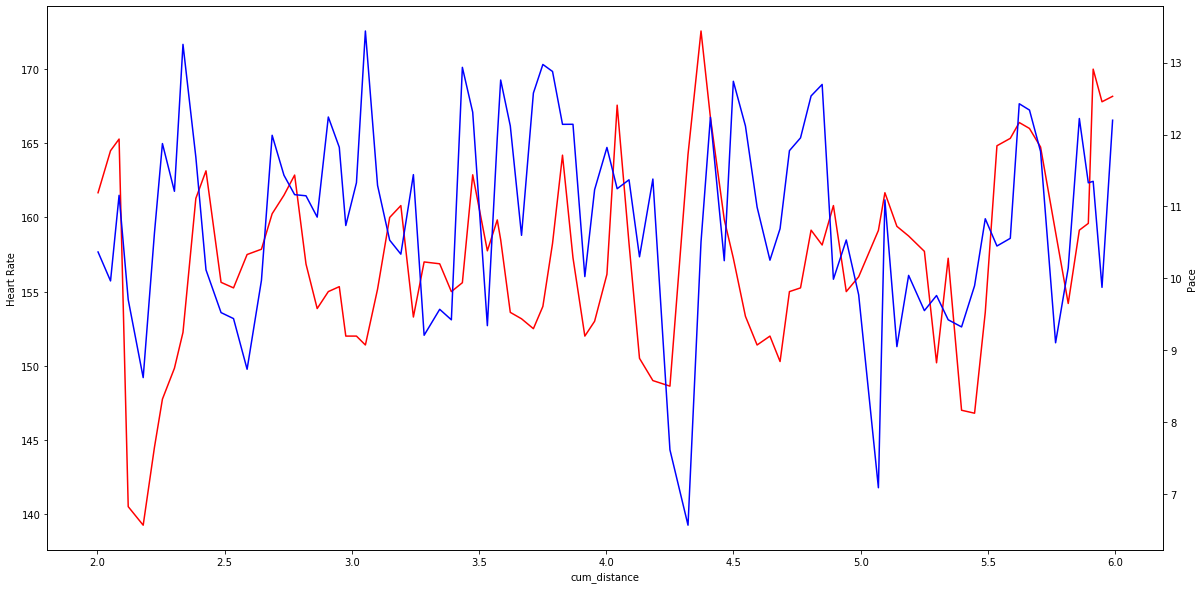

In [135]:
downsample_rate = '30s'
downsample_df = pd.DataFrame()
downsample_df['Pace'] = speed_df_clean.Pace.resample(downsample_rate).mean()
downsample_df['Heart Rate'] = speed_df_clean['Heart Rate'].resample(downsample_rate).mean()
downsample_df['cum_distance'] = speed_df_clean['cum_distance'].resample(downsample_rate).max()

min_dist = 2
max_dist = 6

sns.lineplot(x = 'cum_distance', y = 'Heart Rate', data = downsample_df[(downsample_df['cum_distance']>min_dist) & (downsample_df['cum_distance']<max_dist)], color = 'r')
ax2 = plt.twinx()
sns.lineplot(x='cum_distance', y = 'Pace', data = downsample_df[(downsample_df['cum_distance']>min_dist) & (downsample_df['cum_distance']<max_dist)], color = 'b', ax = ax2)

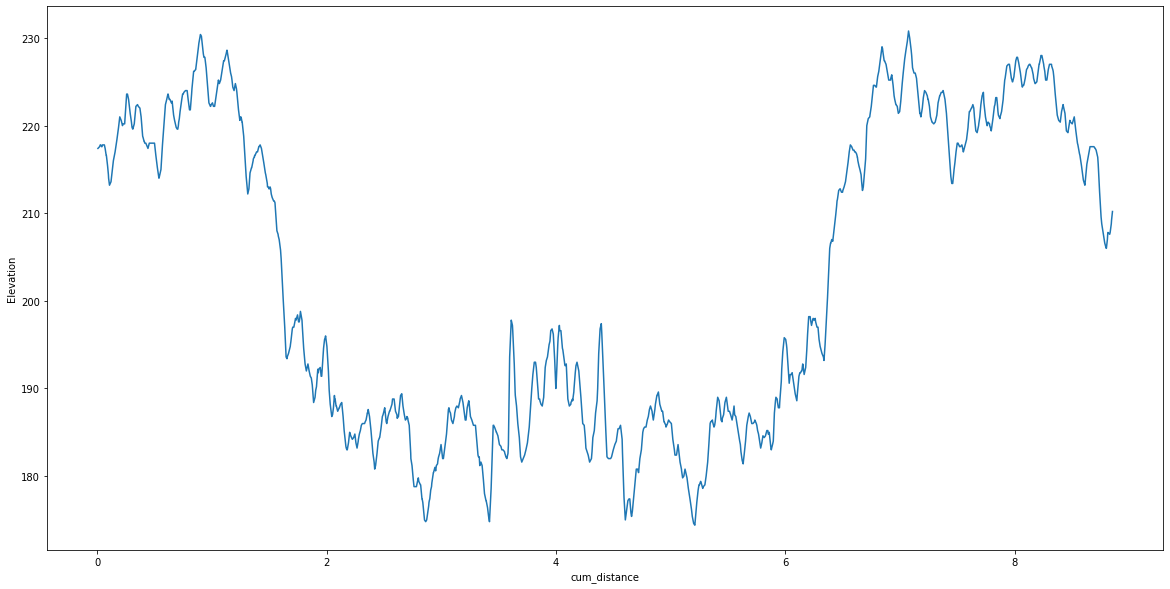

In [138]:
sns.lineplot(x ='cum_distance', y = "Elevation", data = speed_df_clean[(speed_df_clean['cum_distance']>0) & (speed_df_clean['cum_distance']<9)])

Great! So we see a few things. The graph is much easier to view when it is resampled! We also see that pace roughly tracks with HR. There are a few execptions to this, which I think would be best explained by Elevation change. Now, lets make a function to calculate decouple rate. The first method we will use is the method recommended by Training Peaks. We will split the sample in half, and calculate the pace/hr rate for half one, and the pace/hr rate for half two. If there is little variation in these values, then we are not decoupled (higher value means more decoupling). We would prefer a flatter course for this analysis. However, between miles 2 and 6 we should have roughly the same elevation gain and drop in each half. Because of this, we would expect our decoupling analysis to be fairly accurate for this section.

In [141]:
def decouple_rate(HR_Series, Pace_Series):
    #We receive a Heart Rate time series, and a Pace time series with the same index. 
    #Then we calculate decouple rate based on the halfway point.
    #More accurate for flatter courses.
    length = int(len(HR_Series)/2)
    hr1 = HR_Series[:length].mean()
    p1 = Pace_Series[:length].mean()
    hr2 = HR_Series[length:].mean()
    p2 = Pace_Series[length:].mean()
    print(hr1,p1,hr2,p2)
    return ((p1/hr1)-(p2/hr2))/((p1/hr1))
decouple_rate_sample = downsample_df[(downsample_df['cum_distance']>2) & (downsample_df['cum_distance']<6)]
decouple = decouple_rate(decouple_rate_sample['Heart Rate'], decouple_rate_sample['Pace'])
print("Decoupling Rate of: " + str(round(decouple*100,2)) + "% Decoupling. Between 3.5 and 5 is aerobic threshold.")
print("Average Pace of: " +  str(decouple_rate_sample['Pace'].mean()) + " Min/Mile")

155.8875396825397 11.088888504207453 158.37507936507936 10.67649130164241
Decoupling Rate of: 5.23% Decoupling. Between 3.5 and 5 is aerobic threshold.
Average Pace of: 10.88268990292493 Min/Mile


So we see that we have achieved 4.65% decoupling between miles 2 and 6 on the run. THis is about 40 minutes worth of activity. We did not use the begining and end of the run because of elevation change concerns. The average pace during this section was about 10:50 minutes per mile. This looks to be about my current aerobic threshold. Ouch. Current Lactate Threshold is about 8-8:30 per mile, and 5K pace is 7:00 per mile.
<br> <br>
Next I would like to investigate the relationship between HR and Pace. To do this I would like to first look at the relationship between delta HR and delta Pace.

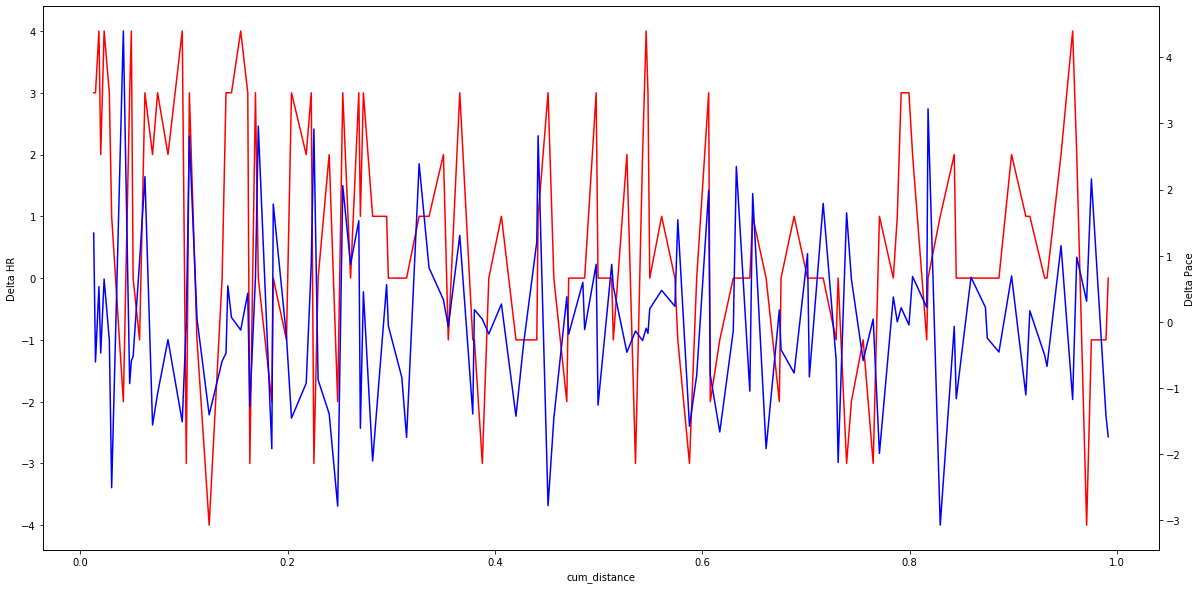

In [118]:
speed_df_clean['Delta HR'] = speed_df_clean['Heart Rate'].diff()
speed_df_clean['Delta Pace'] = speed_df_clean['Pace'].diff()
sns.lineplot(x = 'cum_distance', y = 'Delta HR', data = speed_df_clean[speed_df_clean['cum_distance']<1], color = 'r')
ax2 = plt.twinx()
sns.lineplot(x='cum_distance', y = 'Delta Pace', data = speed_df_clean[speed_df_clean['cum_distance']<1], color = 'b', ax = ax2)
